In [3]:
#microphone check one two what is this!

In [35]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX #pip install statsmodels
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

#from thefuzz import process - not needed anymore

import matplotlib.pyplot as plt
import packaging as p

In [36]:
'''#check counts and names
import pandas as pd, re
from pprint import pprint

xl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")

def norm(s): 
    import re
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def find_header_row(xl, sheet, scan_rows=60):
    raw = xl.parse(sheet, header=None)
    for i in range(min(scan_rows, len(raw))):
        row = [norm(v) for v in raw.iloc[i].tolist()]
        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):
            return i
    return None

s = "2017 Entry & Exit"
hdr = find_header_row(xl, s)
df = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")
pprint([norm(c) for c in df.columns])'''

'#check counts and names\nimport pandas as pd, re\nfrom pprint import pprint\n\nxl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")\n\ndef norm(s): \n    import re\n    s = str(s).lower().strip()\n    s = re.sub(r"[^a-z0-9]+", " ", s)\n    return re.sub(r"\\s+", " ", s).strip()\n\ndef find_header_row(xl, sheet, scan_rows=60):\n    raw = xl.parse(sheet, header=None)\n    for i in range(min(scan_rows, len(raw))):\n        row = [norm(v) for v in raw.iloc[i].tolist()]\n        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):\n            return i\n    return None\n\ns = "2017 Entry & Exit"\nhdr = find_header_row(xl, s)\ndf = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")\npprint([norm(c) for c in df.columns])'

In [37]:
#paths
RAW_STATION_XLSX   = "multi-year-station-entry-and-exit-figures.xlsx"
RAW_STATIONS_CSV   = "TfL_stations.csv"
RAW_PERF_XLSX      = "tfl-tube-performance.xlsx"

OUT_DIR            = "data/processed"
OUT_STATION_FLOW   = f"{OUT_DIR}/station_flow_clean_basic.csv"
OUT_STATIONS_CLEAN = f"{OUT_DIR}/TfL_stations_clean.csv"
OUT_PERF_CLEAN     = f"{OUT_DIR}/tube_performance_clean_basic.csv"

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

#cleanin file #1:
def clean_station_workbook(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    
    target_sheets = [s for s in xl.sheet_names if ("entry" in s.lower() and "exit" in s.lower())]
    for s in target_sheets:
        raw = xl.parse(s, header=None) #raw read+ drop empty rows/cols
        raw = raw.dropna(how="all").dropna(axis=1, how="all")
        if raw.empty:
            continue

        df = raw.copy()
        df.columns = [f"col{i}" for i in range(df.shape[1])] #assume first column holds station names
        
        for c in df.columns[1:]:
            df[c] = pd.to_numeric(df[c], errors="coerce") #coerce non first columns to numeric

        num_cols = [c for c in df.columns[1:] if np.issubdtype(df[c].dtype, np.number)]
        if not num_cols:
            continue
        q90 = {c: df[c].quantile(0.90) for c in num_cols}
        total_col = max(q90, key=lambda k: (q90[k] if pd.notna(q90[k]) else -np.inf)) #choose total as numeric column with highest 90th %

        out = pd.DataFrame({
            "station": df["col0"].astype(str).str.strip().str.title(),
            "annual_entries_exits": df[total_col]})

        out = out.replace({"": np.nan, "nan": np.nan})
        out = out[~out["station"].str.contains(r"^total\b|^counts\b|^grand\b", case=False, na=False)]
        out = out.dropna(subset=["station", "annual_entries_exits"]) #drop junk

        if out["annual_entries_exits"].max(skipna=True) < 100_000:
            out["annual_entries_exits"] = out["annual_entries_exits"] * 1_000_000 #millions to absolute
            
        out["daily_avg_passengers"] = out["annual_entries_exits"] / 365.0 #daily average

        m = re.search(r"(20\d{2})", s)
        out["year"] = int(m.group(1)) if m else np.nan
        
        frames.append(out[["year","station","annual_entries_exits","daily_avg_passengers"]])

    if not frames:
        raise RuntimeError("Station workbook: produced no rows. Check file path or sheet names.")

    station_flow = pd.concat(frames, ignore_index=True).drop_duplicates()
    return station_flow

station_flow = clean_station_workbook(RAW_STATION_XLSX)
station_flow.to_csv(OUT_STATION_FLOW, index=False)
print(f"Wrote {OUT_STATION_FLOW}  rows={len(station_flow)}")
display(station_flow.head(10))


#cleanin file #2:
def clean_stations_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = [re.sub(r"_+", "_", re.sub(r"[^0-9a-zA-Z]+", "_", c)).strip("_").lower() for c in df.columns] #normalize headers
    
    rename_map = {}
    for cand in ["station", "name", "station_name"]:
        if cand in df.columns:
            rename_map[cand] = "station" #pick common columns
            break
    for cand in ["line", "lines"]:
        if cand in df.columns:
            rename_map[cand] = "line"
            break
    for cand in ["latitude","lat"]:
        if cand in df.columns:
            rename_map[cand] = "lat"
            break
    for cand in ["longitude","lon","lng","long"]:
        if cand in df.columns:
            rename_map[cand] = "lon"
            break
    if rename_map:
        df = df.rename(columns=rename_map)

    if "station" in df.columns:
        df["station"] = df["station"].astype(str).str.strip().str.title()
    if "line" in df.columns:
        df["line"] = df["line"].astype(str).str.strip().str.title()

    for c in ["lat","lon"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce") #lat/lon

    keep = [c for c in ["station","line","lat","lon","borough","zone"] if c in df.columns]
    if keep:
        df = df[keep] #keep useful columns

    df = df.drop_duplicates().dropna(how="all")
    return df

stations_clean = clean_stations_csv(RAW_STATIONS_CSV)
stations_clean.to_csv(OUT_STATIONS_CLEAN, index=False)
print(f"Wrote {OUT_STATIONS_CLEAN}  rows={len(stations_clean)}")
display(stations_clean.head(10))


#cleanin file #3:
def clean_tube_performance(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2:
            continue
        
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)} #normalize headers

        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                line_col = hit[0]; break
        if line_col is None:
            obj = df.select_dtypes(exclude=[np.number]).columns
            if len(obj) == 0: 
                continue
            line_col = obj[0] #line column?

        date_series = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                date_series = pd.to_datetime(df[hit[0]], errors="coerce"); break
        if date_series is None and ("year" in cmap and "month" in cmap):
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_series = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce") #date column?

        metric_col = None
        for key in ["excess journey time","ejt","lost customer hours","lch"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                metric_col = hit[0]; break
        if metric_col is None:
            num = df.select_dtypes(include=[np.number]).columns
            if len(num) == 0: 
                continue
            var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0] #metric column?

        tidy = pd.DataFrame({
            "line": df[line_col].astype(str).str.replace(" line","", case=False).str.title().str.strip(),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")})
        if date_series is not None:
            tidy["date"] = pd.to_datetime(date_series, errors="coerce").dt.to_period("M").dt.to_timestamp()
        else:
            tidy["date"] = pd.NaT

        tidy = tidy.dropna(subset=["line"]).drop_duplicates()
        frames.append(tidy[["line","date","metric"]])

    if not frames:
        raise RuntimeError("Performance workbook: produced no rows. Check file path or sheet contents.")
    merged = pd.concat(frames, ignore_index=True)
    # collapse duplicates on same (line,date) by mean
    merged["date"] = pd.to_datetime(merged["date"], errors="coerce")
    merged = (merged.groupby(["line","date"], as_index=False).agg(metric=("metric","mean")))
    return merged

perf_clean = clean_tube_performance(RAW_PERF_XLSX)
perf_clean.to_csv(OUT_PERF_CLEAN, index=False)
print(f"Wrote {OUT_PERF_CLEAN}  rows={len(perf_clean)}")
display(perf_clean.head(10))

Wrote data/processed/station_flow_clean_basic.csv  rows=2968


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329
3,2017,669,121364.0,332.504110
4,2017,741,121018.0,331.556164
5,2017,635,113606.0,311.249315
6,2017,634,112437.0,308.046575
7,2017,719,93742.0,256.827397
8,2017,513,112547.0,308.347945
9,2017,852,86663.0,237.432877


Wrote data/processed/TfL_stations_clean.csv  rows=436


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"
3,Aldgate East,"District, Hammersmith & City"
4,Alperton,Piccadilly
5,Amersham,Metropolitan
6,Angel,Northern
7,Archway,Northern
8,Arnos Grove,Piccadilly
9,Arsenal,Piccadilly


Wrote data/processed/tube_performance_clean_basic.csv  rows=0


,line,date,metric


In [38]:
#paths and imports
RAW_DIR = Path("data/processed")  #new cleaned CSVs

STATION_FLOW_CSV   = RAW_DIR / "station_flow_clean_basic.csv"
STATIONS_CLEAN_CSV = RAW_DIR / "TfL_stations_clean.csv"
PERF_CLEAN_CSV     = RAW_DIR / "tube_performance_clean_basic.csv"

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [39]:
#load + sanity check
station_flow   = pd.read_csv(STATION_FLOW_CSV)
stations_ref   = pd.read_csv(STATIONS_CLEAN_CSV)
perf_clean     = pd.read_csv(PERF_CLEAN_CSV, parse_dates=["date"])

print("station_flow:", station_flow.shape, station_flow.columns.tolist())
print("stations_ref:", stations_ref.shape, stations_ref.columns.tolist())
print("perf_clean:",   perf_clean.shape,   perf_clean.columns.tolist())

display(station_flow.head(3))
display(stations_ref.head(3))
display(perf_clean.head(3))

station_flow: (2968, 4) ['year', 'station', 'annual_entries_exits', 'daily_avg_passengers']
stations_ref: (436, 2) ['station', 'line']
perf_clean: (0, 3) ['line', 'date', 'metric']


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"


,line,date,metric


Using sheet: Key trends | metric: Operated Kms (Peak and Off Peak) | line_col: None→Network | date: synthetic-date
modelling line: Network
{'MAE': 206593.58844530652, 'MAPE': 0.03323625454652527}


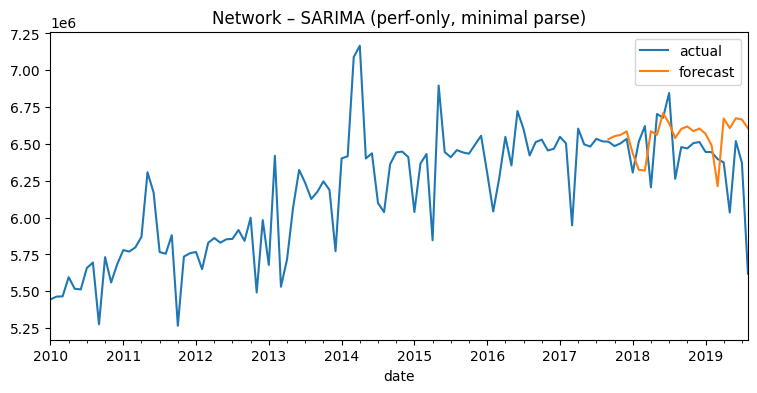

In [40]:
RAW_PERF_XLSX = Path("tfl-tube-performance.xlsx")  #raw workbook
HAS_PERF = RAW_PERF_XLSX.exists()

if not HAS_PERF:
    print ("Skipping performance modelling as tfl-tube-performance.xlsx not found")
    
    
#minimal builder - pull  from workbook
def build_perf_minimal(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    chosen = None
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2: continue
        #normalise headers/ simple lookups
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}

        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            #coerce everything except first text-like col
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            continue

        #pick metric = numeric col with largest variance - can skip obvious keys?
        skip = {cmap[k] for k in cmap if k in {"year","month","period"}} & set(df.columns)
        cand = [c for c in num_cols if c not in skip]
        if not cand: cand = num_cols
        var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in cand})
        metric_col = var.sort_values(ascending=False).index[0]

        #line column? - this is a test, not needed. update: it works!
        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit: line_col = hit[0]; break

        #date column? this is a test, not needed. update: it works!
        date_s = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit:
                try:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce")
                except Exception:
                    date_s = None
                break
        if date_s is None and "year" in cmap and "month" in cmap:
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_s = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")

        #build tidy
        tidy = pd.DataFrame({
            "line": (df[line_col].astype(str) if line_col else "Network"),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")})
        if date_s is not None:
            tidy["date"] = pd.to_datetime(date_s, errors="coerce")
        else:
            #synthetic monthly index starting at jan of plausible yr? 
            n = len(tidy)
            start_year = 2010
            tidy["date"] = pd.date_range(f"{start_year}-01-01", periods=n, freq="MS")

        #cleaning
        tidy = (tidy.replace({"": np.nan, "nan": np.nan}).dropna(subset=["metric"]).assign(line=lambda d: d["line"].astype(str).str.replace(" line","", case=False).str.title().str.strip()))
        tidy["date"] = pd.to_datetime(tidy["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
        if tidy.empty: 
            continue

        chosen = (s, metric_col, line_col, "real-date" if date_s is not None else "synthetic-date", tidy)
        break

    if chosen is None:
        raise RuntimeError("Could not find any usable numeric series in the performance workbook.")
    s, metric_col, line_col, date_mode, tidy = chosen
    print(f"Using sheet: {s} | metric: {metric_col} | line_col: {line_col or 'None→Network'} | date: {date_mode}")
    #collapse duplicates for line, date
    tidy = tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
    return tidy

#building perf and model one series
perf = build_perf_minimal(RAW_PERF_XLSX)

#pick a line with the most rows/ 'Netwoork'
line = perf["line"].value_counts().index[0]
print("modelling line:", line)

#monthly series (note to self: try float64 if TypeError occurs? 
dfl = (perf[perf["line"]==line].sort_values("date").set_index("date").asfreq("MS"))
y = dfl["metric"].astype("float64").interpolate(limit_direction="both")

#split
if len(y) < 8: raise RuntimeError(f"Not enough monthly points to model (have {len(y)}).")
split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]

#fit + predict !
model = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
y_hat = res.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean

#metrics + plot !
mae  = mean_absolute_error(y_te, y_hat); mape = mean_absolute_percentage_error(y_te, y_hat)
print({"MAE": mae, "MAPE": mape})
y.plot(label="actual", figsize=(9,4)); y_hat.plot(label="forecast")
plt.title(f"{line} – SARIMA (perf-only, minimal parse)"); plt.legend(); plt.show()

In [41]:
'''print(perf_clean.columns.tolist())
print(perf_clean.head(3))'''

'print(perf_clean.columns.tolist())\nprint(perf_clean.head(3))'

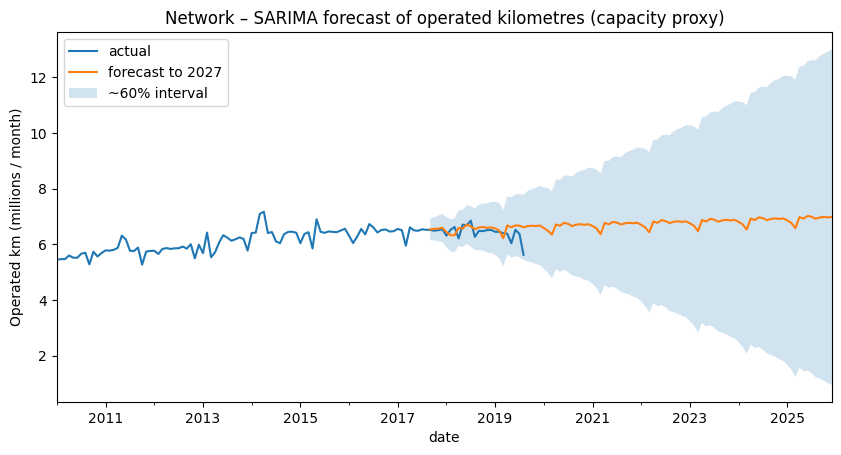

Saved data/processed/network_operated_km_forecast_to_2027.csv


In [42]:
#rebuilding y/res - use the perf-only minimal build you ran earlier
try:
    y
    res
except NameError:
    import pandas as pd, numpy as np, re
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

    xl = pd.ExcelFile("tfl-tube-performance.xlsx")
    #pick first usable sheet & numeric metric (note to self: can use same logic as above)
    def build_perf_minimal(xl):
        for s in xl.sheet_names:
            df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
            if df.shape[1] < 2: continue
            cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
            cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}
            
            #numeric
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num: continue
            var = pd.Series({c: df[c].var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0]
            
            #date ?
            date_s = None
            for key in ["period start","start date","date"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce"); break
            if date_s is None and "year" in cmap and "month" in cmap:
                yv = pd.to_numeric(df[cmap["year"]], errors="coerce")
                mv = pd.to_numeric(df[cmap["month"]], errors="coerce")
                date_s = pd.to_datetime(dict(year=yv, month=mv, day=1), errors="coerce")
                
            #line
            line_col = None
            for key in ["line","line name","route"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit: line_col = hit[0]; break
            tidy = pd.DataFrame({
                "line": (df[line_col].astype(str) if line_col else "Network"),
                "metric": pd.to_numeric(df[metric_col], errors="coerce")})
            
            tidy["date"] = pd.to_datetime(date_s, errors="coerce") if date_s is not None else pd.date_range("2010-01-01", periods=len(tidy), freq="MS")
            tidy = (tidy.dropna(subset=["metric"])
                        .assign(line=lambda d: d["line"].astype(str).str.replace(" line","", case=False).str.title().str.strip()))
            tidy["date"] = tidy["date"].dt.to_period("M").dt.to_timestamp()
            if not tidy.empty:
                return tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
        raise RuntimeError("No usable sheet found.")

    perf = build_perf_minimal(xl)
    line = perf["line"].value_counts().index[0]
    dfl = (perf[perf["line"]==line].sort_values("date").set_index("date").asfreq("MS"))
    y = dfl["metric"].astype("float64").interpolate(limit_direction="both")
    split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
    res = SARIMAX(y.iloc[:split_idx], order=(1,1,1), seasonal_order=(1,1,1,12),enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

#forecast to dec'27
import pandas as pd
last = y.index[-1]
end = pd.Timestamp("2027-12-01")
steps = max(1, (end.year - last.year)*12 + (end.month - last.month))

fc = res.get_forecast(steps=steps)
y_fc = fc.predicted_mean

#60% CI band - attempting formatting, dont spend too long on this
ci = fc.conf_int(alpha=0.40)  #1-0.40 = 60% interval
ci.columns = ["lower","upper"] if len(ci.columns)==2 else ci.columns

#plotting in millions of km
import matplotlib.pyplot as plt
y_m = y/1_000_000
y_fc_m = y_fc/1_000_000
ci_m = ci/1_000_000

plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
try:
    plt.fill_between(ci_m.index, ci_m.iloc[:,0], ci_m.iloc[:,1], alpha=0.2, label="~60% interval")
except Exception:
    pass
plt.ylabel("Operated km (millions / month)")
plt.title("Network – SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend(); plt.show()

#save a tidy CSV
out = (pd.concat([y.rename("actual"), y_fc.rename("forecast")], axis=1).reset_index().rename(columns={"index":"date"}))
out.to_csv("data/processed/network_operated_km_forecast_to_2027.csv", index=False)
print("Saved data/processed/network_operated_km_forecast_to_2027.csv")

#### For 001:
The print line at the top told us the metric we found:
metric: Operated Kms (Peak and Off Peak) and line_col: None→Network.
So the chart is network-wide operated kilometres per month (a supply/capacity measure), not delays yet.
Y-axis is big because values are in kilometres (e.g., ~6,500,000 km). Rescaled to millions of km so it’s readable.
Dates are synthetic monthly (no true date column on that sheet). Fine for 001 to show the method; later can replace with real dates (from another sheet/API).
I can demonstrate a statistical baseline (SARIMA) running end-to-end on real-ish operational data.
First, I can forecast capacity/load; next, I'll switch to delay-centric metrics like EJT/LCH and add demand as an exogenous driver.
That satisfies the “multiple solutions / roadmap” angle
What it is: I built a monthly SARIMA to forecast operated kilometres (a capacity proxy).
Why it matters: Capacity tends to fall during planned works and major disruptions. Forecasting capacity helps anticipate commuter impact windows.
Honesty about limits: “This is a proxy. For 002, I'll switch to delay metrics (EJT/LCH) and add demand (from station entries/exits) + real-time API signals.
Roadmap / multiple approaches:
Statistical: SARIMA/SARIMAX
ML: Gradient Boosting or XGBoost classification of (line × hour) delay risk
Hybrid: ML with SARIMA residuals or features (lags, events)

In [43]:
######### STATION LINE MAPPING
def primary_line(s):
    if pd.isna(s): return np.nan
    part = re.split(r"\s*(?:/|;|,|&|\+|\band\b)\s*", str(s), flags=re.I)[0]  #first token only
    return part.strip().title() if part.strip() else np.nan

#fallback to first col if no station col in both frames
if "station" not in station_flow.columns:
    station_flow = station_flow.rename(columns={station_flow.columns[0]: "station"})
if "station" not in stations_ref.columns:
    stations_ref = stations_ref.rename(columns={stations_ref.columns[0]: "station"})

#normalise names
station_flow["station"] = station_flow["station"].astype(str).str.strip().str.title()
stations_ref["station"] = stations_ref["station"].astype(str).str.strip().str.title()

#finding 'line'/'lines' col if none, make NaN - hopefully merge should still work. update: it works!
line_col = next((c for c in stations_ref.columns if re.search(r"\blines?\b", str(c), flags=re.I)), None)
stations_ref["line"] = stations_ref[line_col].astype(str) if line_col else np.nan

#derive primary_line + build mapping
stations_ref["primary_line"] = stations_ref["line"].apply(primary_line)
stn_map = (stations_ref[["station","primary_line"]].dropna().drop_duplicates().rename(columns={"primary_line":"line"}))

#merge to attach one line per station
sf_with_line = station_flow.merge(stn_map, on="station", how="left")

#coverage - investigate other methods if pandas doesnt work for formatting
unmapped = sf_with_line["line"].isna().mean()
coverage = 1.0 - unmapped
print(f"primary-line mapping coverage: {float(coverage):.1%}  (unmapped={float(unmapped):.1%})")
display(sf_with_line.head(5))

primary-line mapping coverage: 0.0%  (unmapped=100.0%)


,year,station,annual_entries_exits,daily_avg_passengers,line
0,2017,Nan,253.0,0.693151,NaN
1,2017,625,149150.0,408.630137,NaN
2,2017,747,147574.0,404.312329,NaN
3,2017,669,121364.0,332.504110,NaN
4,2017,741,121018.0,331.556164,NaN


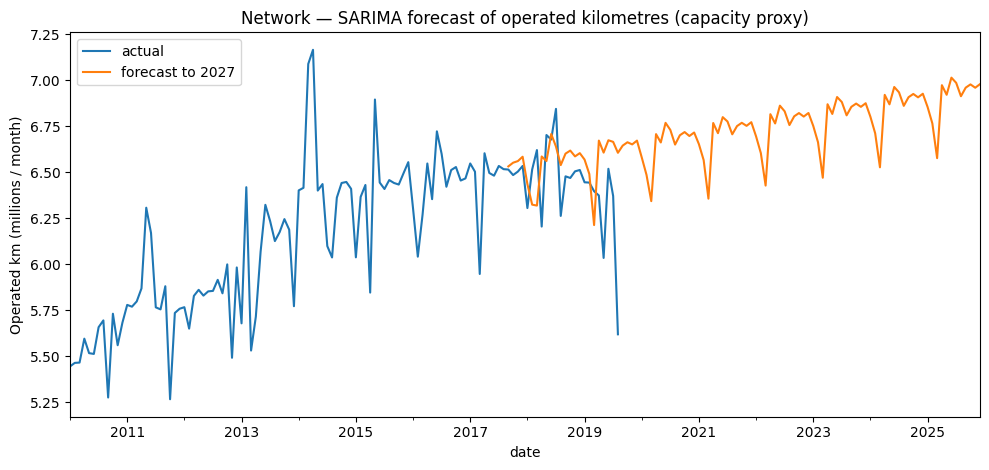

Saved: figures/network_capacity_forecast_to_2027.png
Saved: data/processed/network_operated_km_forecast_to_2027.csv


In [44]:
#saving final figures + forecast CSVs
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("data/processed"); OUT_DIR.mkdir(exist_ok=True, parents=True)

#y = 'your' (client's) monthly series (use float), y_fc = forecast to 2027 (from above)
y_m, y_fc_m = y/1_000_000, y_fc/1_000_000  #millions

plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
plt.ylabel("Operated km (millions / month)")
plt.title("Network — SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend()
plt.tight_layout()
fig_path = FIG_DIR / "network_capacity_forecast_to_2027.png"
plt.savefig(fig_path, dpi=220)
plt.show()

out = (pd.concat([y.rename("actual_km"), y_fc.rename("forecast_km")], axis=1).reset_index().rename(columns={"index":"date"}))
csv_path = OUT_DIR / "network_operated_km_forecast_to_2027.csv"
out.to_csv(csv_path, index=False)

print("Saved:", fig_path)
print("Saved:", csv_path)

In [45]:
#exporting metrics table as CSV
metrics_df = pd.DataFrame({
    "metric": ["MAE (km)", "MAPE"],
    "value":  [mae, mape]})

metrics_path = OUT_DIR / "forecast_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
metrics_df

,metric,value
0,MAE (km),206593.588445
1,MAPE,0.033236


In [46]:
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

def _to_monthly(df):
    #expects columns date, metric as line-wise grouping done
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date", "metric"])
    d["date"] = d["date"].dt.to_period("M").dt.to_timestamp()
    return (d.groupby("date", as_index=False).agg(metric=("metric","mean")).sort_values("date"))

#try common variable names from above
net = None
for cand in ("perf_month", "perf_clean", "perf"):
    if cand in globals():
        df = globals()[cand]
        #perf_month likely has [line, date, metric]; perf_clean/perf may vary
        if {"date","metric"}.issubset(df.columns):
            net = _to_monthly(df[["date","metric"]])
            break

if net is None or net.empty:
    print("Skipping calendar heatmap as no performance monthly data available.")
else:
    cal = net.copy()
    cal["year"] = cal["date"].dt.year
    cal["month"] = cal["date"].dt.month
    pivot = cal.pivot_table(index="year", columns="month", values="metric", aggfunc="mean")

    plt.figure(figsize=(10,4.6))
    plt.imshow(pivot.values, aspect="auto", cmap=plt.cm.Pastel1)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.title("CommuTech — Year x month intensity (pastel)")
    plt.xlabel("month"); plt.ylabel("year"); plt.tight_layout()
    outp = FIGS / "commutech_calendar_intensity_pastel.png"
    plt.savefig(outp, dpi=220); plt.show()
    print("Saved:", outp)

Skipping calendar heatmap as no performance monthly data available.


In [47]:
#things need updating
#does this work?

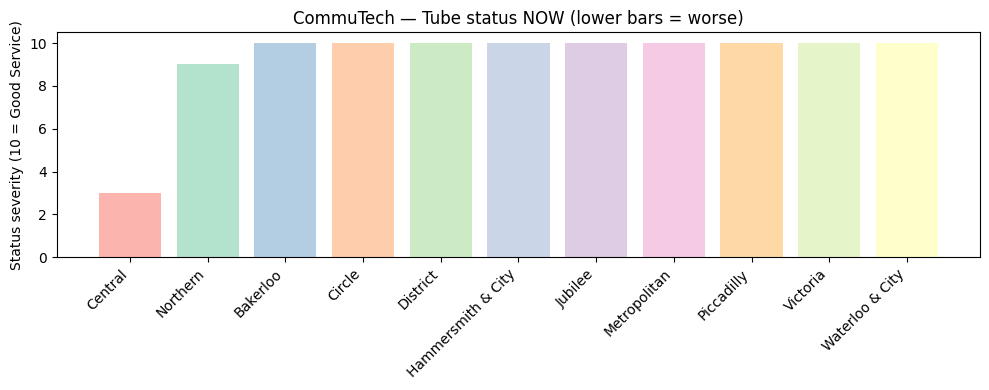

• Right now: 82% of lines are 'Good Service'


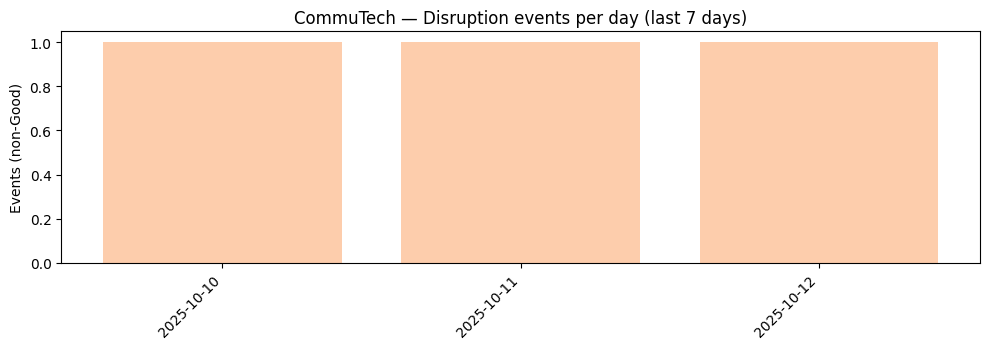

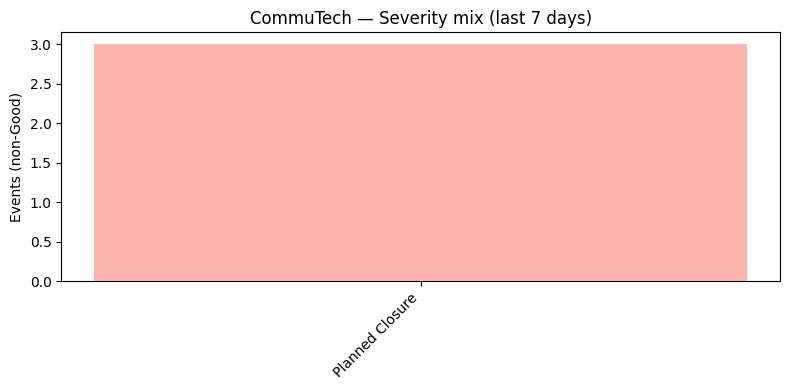

• Last 7 days: 3 non-Good events across the network


In [55]:
import os, requests

BASE = "https://api.tfl.gov.uk"
KEY = os.getenv("2361c198e867428585690a8d9431029e")

FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)
P1, P2 = plt.cm.Pastel1, plt.cm.Pastel2
def pastel(i): return (P1 if i%2==0 else P2)( (i//2) % 8 )
 
def get(path, params=None):
    p = dict(params or {})
    if KEY: p["app_key"] = KEY
    r = requests.get(f"{BASE}{path}", params=p, timeout=15)
    r.raise_for_status()
    return r.json()

#1. snapshot NOW (one call + one small transform)
snap_raw = get("/Line/Mode/tube/Status", {"detail":"true"})
snap = pd.DataFrame([{
    "line": l.get("name"),
    "severity": min([s.get("statusSeverity",10) for s in l.get("lineStatuses",[])] or [10]),
    "status":   next((s.get("statusSeverityDescription","Good Service") 
                      for s in l.get("lineStatuses",[]) if s.get("statusSeverity",10)<10), "Good Service")} for l in snap_raw])

if not snap.empty:
    order = snap.sort_values("severity")["line"].tolist()
    plt.figure(figsize=(10,4))
    cols = [pastel(i) for i in range(len(order))]
    plt.bar(order, [snap.loc[snap.line==ln,"severity"].iloc[0] for ln in order], color=cols)
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 10.5)
    plt.ylabel("Status severity (10 = Good Service)")
    plt.title("CommuTech — Tube status NOW (lower bars = worse)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_snapshot_pastel.png", dpi=220); plt.show()
    print(f"• Right now: {(snap['severity']==10).mean()*100:.0f}% of lines are 'Good Service'")

#2. last 7 days disruptions (per-day bars) + 3) severity mix
line_ids = [x["id"] for x in get("/Line/Mode/tube")]
end = datetime.utcnow().date(); start = end - timedelta(days=7)

rows = []
for lid in line_ids:
    try:
        hist = get(f"/Line/{lid}/Status/{start}/to/{end}", {"detail":"true"})
    except requests.HTTPError:
        continue
    for it in hist:
        ln = it.get("name")
        for st in it.get("lineStatuses", []):
            sev = st.get("statusSeverity", 10)
            if sev >= 10:  # skip Good Service
                continue
            sev_desc = st.get("statusSeverityDescription", "Non-Good")
            vps = st.get("validityPeriods") or [{}]  # sometimes empty → still count once
            for vp in vps:
                dt = vp.get("fromDate") or it.get("created")
                if not dt: continue
                rows.append({"date": pd.to_datetime(dt, errors="coerce").date(), "line": ln, "sev": sev_desc})

trend = pd.DataFrame(rows)

if not trend.empty:
    #per-day count
    daily = trend.groupby("date").size().reset_index(name="events").sort_values("date")
    plt.figure(figsize=(10,3.6))
    plt.bar(daily["date"].astype(str), daily["events"], color=pastel(3))
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Events (non-Good)")
    plt.title("CommuTech — Disruption events per day (last 7 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_7day_trend_pastel.png", dpi=220); plt.show()

    #severity mix
    mix = trend["sev"].value_counts().reset_index()
    mix.columns = ["severity","count"]
    plt.figure(figsize=(8,4))
    plt.bar(mix["severity"], mix["count"], color=[pastel(i) for i in range(len(mix))])
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Events (non-Good)")
    plt.title("CommuTech — Severity mix (last 7 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_severity_mix_pastel.png", dpi=220); plt.show()

    print(f"• Last 7 days: {int(daily['events'].sum())} non-Good events across the network")
else:
    print("No non-Good events returned for the last 7 days.")

In [56]:
#is save working?
